# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho HiTec portfolio

#### Lấy dữ liệu của HiTec porfolio

In [4]:
series <- ts(data = data$HiTec, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-25.920  -2.675   1.190   1.066   4.890  20.760 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

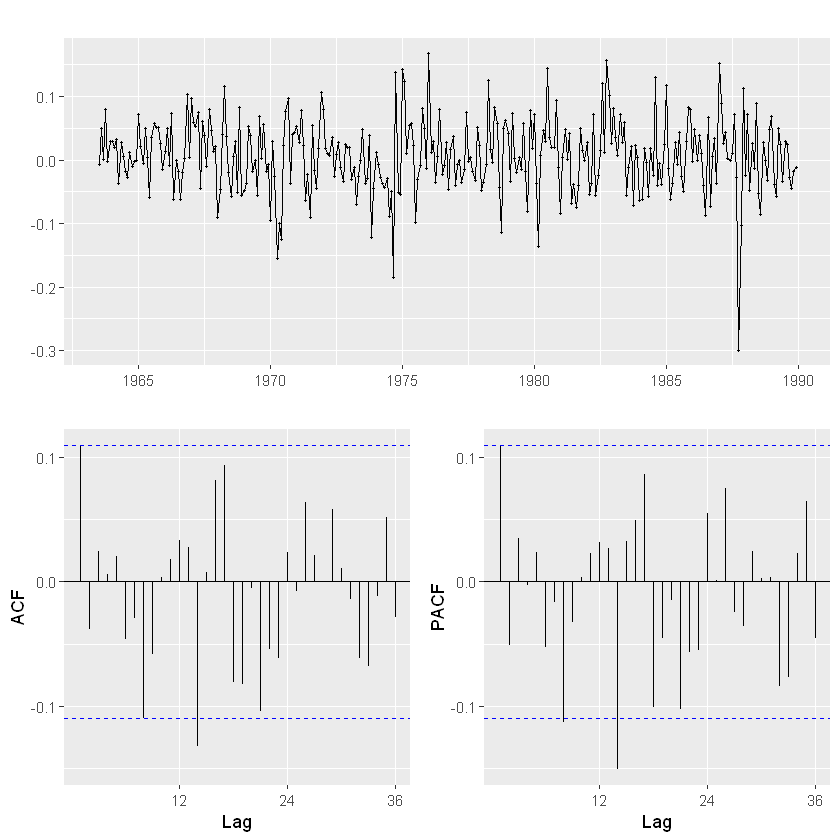

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.1214  0.0067
s.e.  0.0584  0.0036

sigma^2 estimated as 0.003311:  log likelihood=457.72
AIC=-909.44   AICc=-909.37   BIC=-898.16


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 28.165, df = 22, p-value = 0.1703

Model df: 2.   Total lags used: 24



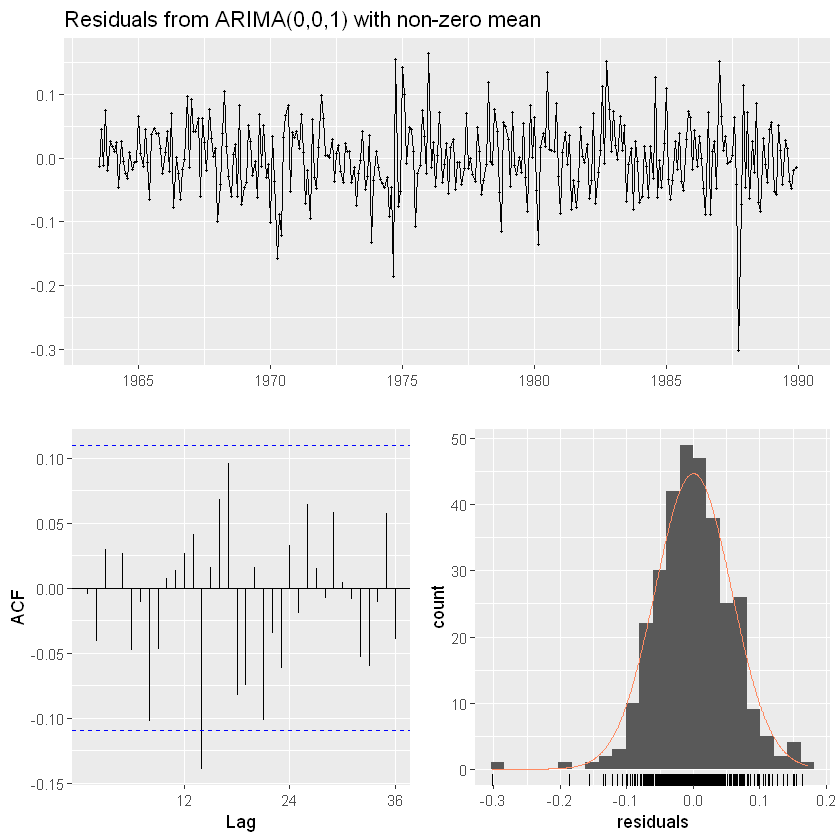

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,0,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-907.1897,-907.1516,-899.6656,5.774597
ARIMA001,-909.4423,-909.3659,-898.1561,5.741241
ARIMA002,-908.0823,-907.9545,-893.0341,5.735386
ARIMA100,-909.0354,-908.9589,-897.7492,5.744376
ARIMA101,-909.2747,-909.1470,-894.2265,5.722865
ARIMA102,-908.1086,-907.9163,-889.2984,5.717413
ARIMA200,-907.8517,-907.7239,-892.8035,5.737234
ARIMA201,-908.0903,-907.8980,-889.2801,5.717239
ARIMA202,-905.9993,-905.7292,-883.4270,5.718092


Mô hình ARIMA(2,0,1) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,1) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,1))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 6.845626

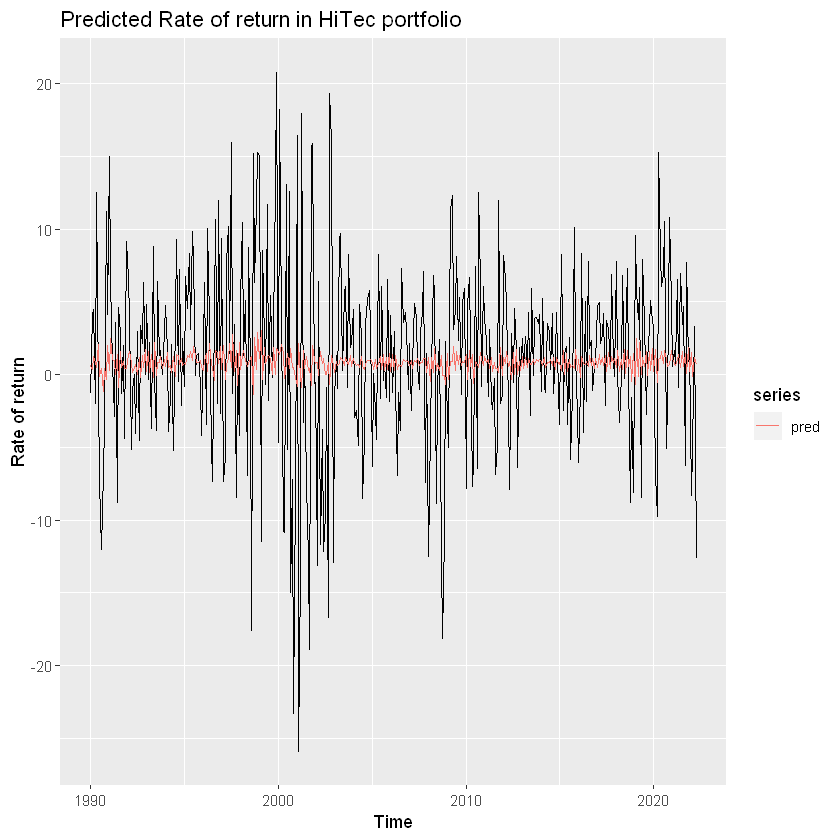

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in HiTec portfolio")

In [9]:
as.numeric(pred)

[1]  0.649515819  0.362746203  1.256234867  0.812357020  0.455573824
  [6]  2.090904330 -0.102377729  0.430884184 -1.179587646  0.444912134
 [11] -0.309748363  1.997608398  0.297665490  2.504221989  1.049581020
 [16]  0.987574078 -0.016160010  1.357442469 -0.862109698  1.557628737
 [21]  0.498134883  0.870142454  0.444591581  0.437787505  1.356659714
 [26]  1.573132105  0.857437531  0.138280818  0.447438312  0.691762073
 [31]  0.002033049  1.163128370 -0.214135255  1.333533361  0.480618886
 [36]  1.711006280  0.186099074  1.613476181  0.118334235  1.360808080
 [41] -0.232496225  2.183519254 -0.072350398  0.849309066  0.817661187
 [46]  1.209208854  0.409777123  1.056692573  0.573661613  1.513758692
 [51]  0.471935959  0.595012735  0.148427057  1.221382853 -0.119263796
 [56]  1.364223027  1.308012860  0.709253964  1.109358747  0.654556897
 [61]  0.772225080  0.705657160  1.318400799  1.158502757  1.586853193
 [66]  0.943670516  1.920215337  1.408361052  0.828626835  0.813650036
 [71]  0.987482340  0.564226397  0.305728373  0.967945701  1.464176684
 [76]  0.202451519  2.100197298  0.784840203  0.489294978 -0.406379878
 [81]  1.651088633  1.489184486  0.762193624  1.922961064  0.351804748
 [86]  1.967531663 -0.367848420  0.713120811  1.102354107  2.104938909
 [91]  0.478215972  2.754615409  0.219930558  1.684090041 -0.727018499
 [96]  2.201894860  0.339257072  1.311604355  1.661824440  0.963290772
[101]  0.546665114  0.779524664  1.112173500  1.246481228 -1.372391715
[106]  2.567477192  0.358132126  2.894390696  1.079987665  3.057483286
[111] -0.372908779  1.844679933  0.735714887  1.175075463  1.337510513
[116]  1.079068884 -0.009957783  1.886173144  0.031569747  1.811796088
[121]  1.613706364  1.378987929  2.063911118  1.532088073 -0.299808690
[126]  0.739608846  1.434741848  0.443703784  1.787268466  0.498642338
[131]  0.517170722 -0.216713177 -0.815615890  2.135550589 -0.083327940
[136] -0.874037979  1.620693562  0.394713170  1.238415339  0.247057870
[141]  0.404549161 -0.782333157  1.972959610  1.057142125  0.791943856
[146]  0.813234715 -0.090875524  1.564935124  0.732725081  1.081764604
[151]  0.024746376 -0.018222392  0.817360509 -0.655979556  1.318662041
[156]  0.645580492  0.142209199  0.929861956  0.605620797  0.756090281
[161]  1.187158748  1.020274093  0.636524177  1.162651173  0.858917076
[166]  0.686689722  1.291272861  0.567998988  1.080625174  0.828737140
[171]  0.614482589  0.706129049  0.467025956  1.211038141  0.624795070
[176]  0.359682604  0.671542463  0.953673451  0.932307210  1.019424070
[181]  0.812837158  0.332919269  1.001640452  0.383682413  0.692165527
[186]  1.220024703  0.343981334  1.388534994  0.286115904  1.157851779
[191]  0.336925675  1.428097636  0.194333573  1.399343575  0.247448564
[196]  1.295208437  0.325031402  0.713082233  0.639548509  0.579340146
[201]  1.051434417  0.913675141  0.980235516  0.864156400  0.654683837
[206]  0.931584710  0.444948254  0.988757312  0.856870506  1.086175311
[211]  0.597456633  0.839381168  0.813412964  1.095391418  1.076797001
[216]  0.167200653  1.150605996 -0.486978293  1.205307310  0.141183143
[221]  1.780252492  0.312248621  0.758972979  0.286166274  1.275192622
[226] -0.078887719 -0.040863714 -0.660610763  1.428185689 -0.313818762
[231]  0.927672416  0.915091062  1.957188438  0.290035401  1.575775974
[236]  0.708541163  1.307605166  0.639175802  0.884512443  0.809580605
[241]  1.361544069 -0.370281706  1.654061119  0.561280127  1.390485435
[246] -0.584220363  0.892185018  0.698982850  0.478489385  1.496249278
[251]  1.057978876  0.592545880  1.235286147  0.799839983  1.010949942
[256]  0.398253674  1.202152252  0.239069792  0.861195200  0.383772127
[261]  0.387899908  0.160381478  1.889579603 -0.058607961  1.204296659
[266]  0.758058840  1.591947492  0.559623195  0.923697926 -0.341638205
[271]  1.518046576 -0.020762792  1.752679429  0.021595541  0.892188120
[276]  0.297709924  1.208057658  0.404512980  1.156087609  0.478717936
[281]  1.085505940  0.6852